In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from WelfareMeasures import *
from functions_njit import tax_rate_fct
from bernoulli_distribution import Bernoulli
from help_functions_non_njit import *
from graph_format import *
# load local model file and initialize model class
from model import ModelClass
from scipy.optimize import minimize

# Load original model

In [2]:
model = ModelClass() # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve(do_print=False)
%time model.simulate()

CPU times: total: 6min 1s
Wall time: 1min 24s
CPU times: total: 30.1 s
Wall time: 25.1 s


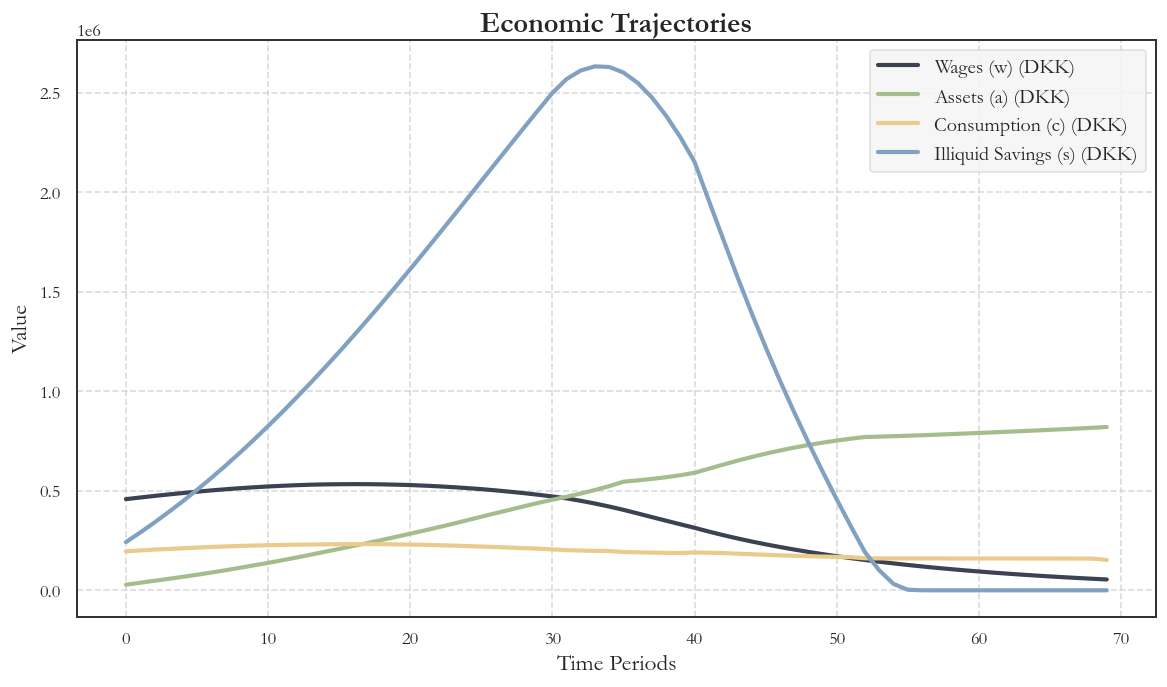

In [3]:
time = np.arange(par.T)
data_dict_basic = {
    "Wages (w)": {"data": np.mean(model.sim.w[:], axis=0), "unit": "DKK"},
    "Assets (a)": {"data": np.mean(model.sim.a[:], axis=0), "unit": "DKK"},
    "Consumption (c)": {"data": np.mean(model.sim.c[:], axis=0), "unit": "DKK"},
    "Illiquid Savings (s)": {"data": np.mean(model.sim.s[:], axis=0), "unit": "DKK"},
}

plot_simulation_one_graph(data_dict_basic, time, title="Economic Trajectories")

# Counter factual

In [4]:
# Change parameters and re-solve
theta = [36]
theta_names = ['retirement_age']

# theta = [0.03]
# theta_names = ['r_a']

og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)


# Compare models 

Expected welfare  before parameter changes: -28.556714387700502
Expected welfare after parameter changes: -28.569438950882574
Consumption at every age before the policy change must change with -0.3 pct. to keep the same utility, and analytically: -0.3 pct.
[9100. 9100. 9137. 9070. 9068. 9106. 9075. 9070. 9063. 9045. 9016. 9034.
 9019. 8964. 8917. 8949. 8913. 8882. 8867. 8818. 8786. 8739. 8691. 8679.
 8598. 8525. 8464. 8424. 8354. 8270. 7840. 6823. 6008. 5218. 4434. 3799.
 3204. 2663. 2254. 1828.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[9.100e+03 9.100e+03 9.137e+03 9.070e+03 9.068e+03 9.106e+03 9.075e+03
 9.070e+03 9.063e+03 9.045e+03 9.016e+03 9.034e+03 9.019e+03 8.964e+03
 8.917e+03 8.949e+03 8.913e+03 8.882e+03 8.867e+03 8.818e+03 8.786e+03
 8.739e+03 8.691e+03 8.679e+03 8.598e+03 8.525e+03 8.464e+03 8.424e+03
 8.354e+03 8.270e+03 8.189e+03 7

c:\Users\Peter\Design_retirement\WelfareMeasures.py:81: RuntimeWarning: Mean of empty slice
  sim_og_h = np.nanmean(sim_og_h_ex_1, axis=0)# age specific average
c:\Users\Peter\Design_retirement\WelfareMeasures.py:82: RuntimeWarning: Mean of empty slice
  sim_new_h = np.nanmean(sim_new_h_ex_1, axis=0) # age specific average


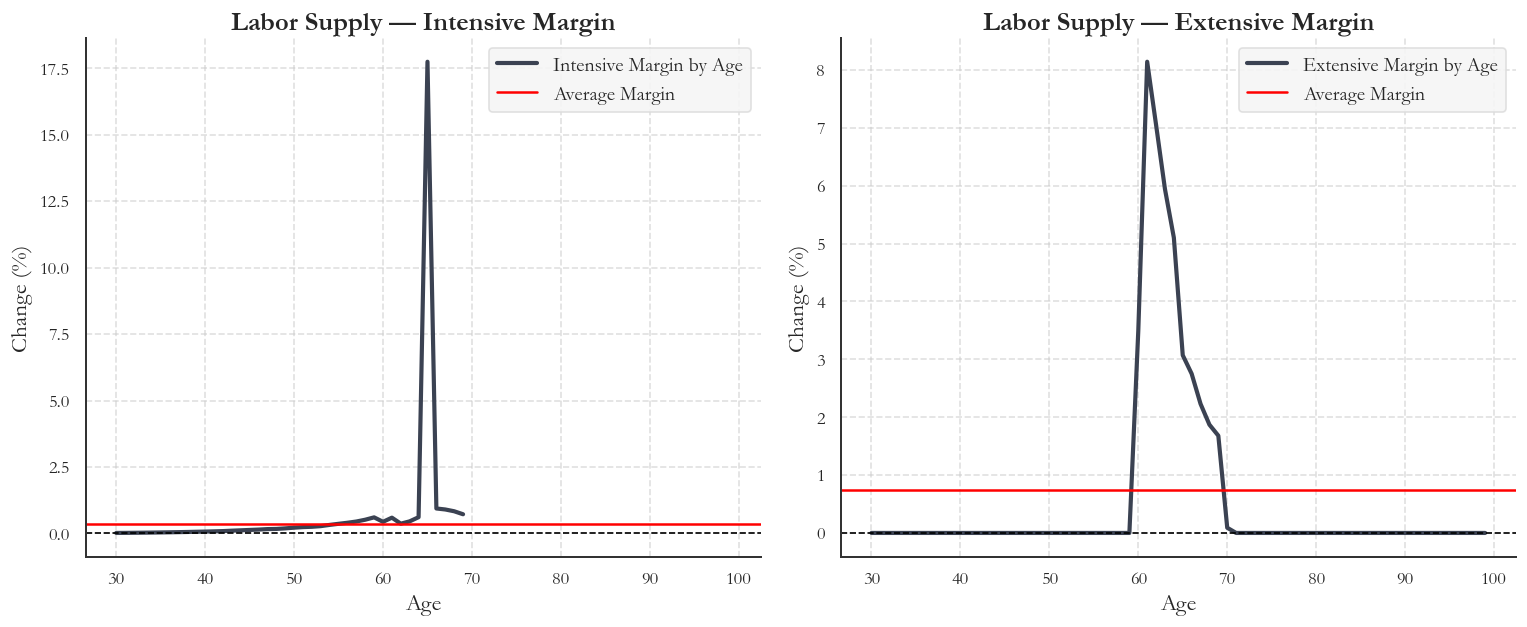

In [5]:
# Compare models 
consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= True, the_method = 'brentq')
intensive_margin, extensive_margin, intensive_margin_age, extensive_margin_age = labor_elasticity(og_model, new_model)


plot_labor_margins_by_age(
    intensive_age=intensive_margin_age,
    extensive_age=extensive_margin_age,
    avg_intensive=intensive_margin,
    avg_extensive=extensive_margin,
    age_start=par.start_age,
    title_prefix="Labor Supply — ",
    save_title="counterfactual_labor_margins_by_age.png"
)

In [22]:
(np.sum(new_model.sim.h) - np.sum(og_model.sim.h))/np.sum(og_model.sim.h)

0.016444665285781535

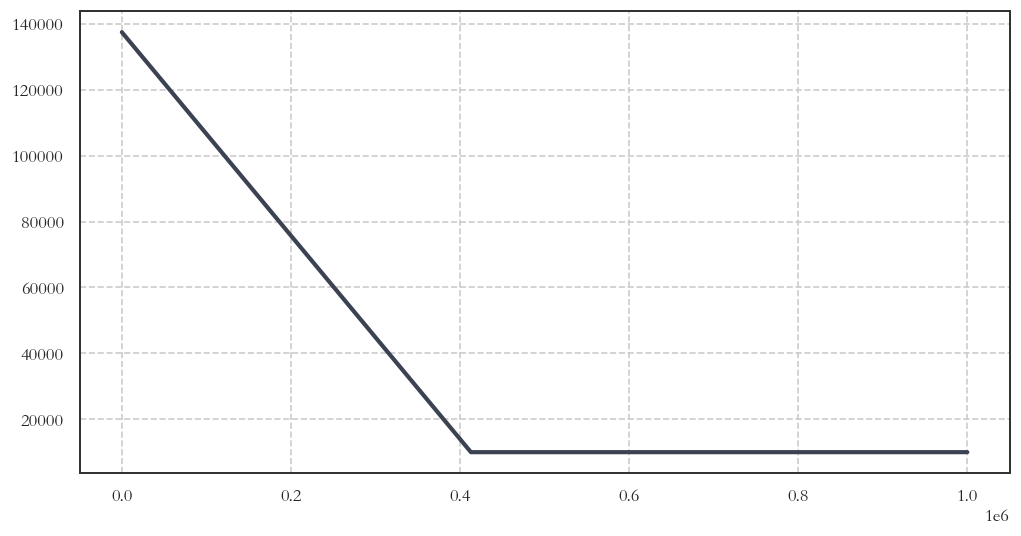

In [7]:
income_list = []

for income in range(1_000_000):
    income_list.append(max(par.chi_base, par.chi_total - income*par.rho))

plt.plot(income_list)

In [8]:
par.unemployment_benefit

array([123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167, 123918.13165167, 123918.13165167,
       123918.13165167, 123918.13165167,  92895.8173852 ,  92895.8173852 ,
        92895.8173852 ,  92895.8173852 ,  92895.8173852 ,  92895.8173852 ,
        92895.8173852 ,  92895.8173852 ,  92895.8173852 ,  92895.8173852 ,
        92895.8173852 ,  92895.8173852 ,  92895.8173852 ,  92895.8173852 ,
        92895.8173852 ,  92895.8173852 ,  92895.8173852 ,  92895.8173852 ,
        92895.8173852 ,  92895.8173852 ,  92895.8173852 ,  92895.8173852 ,
        92895.8173852 ,  

# comparison of means

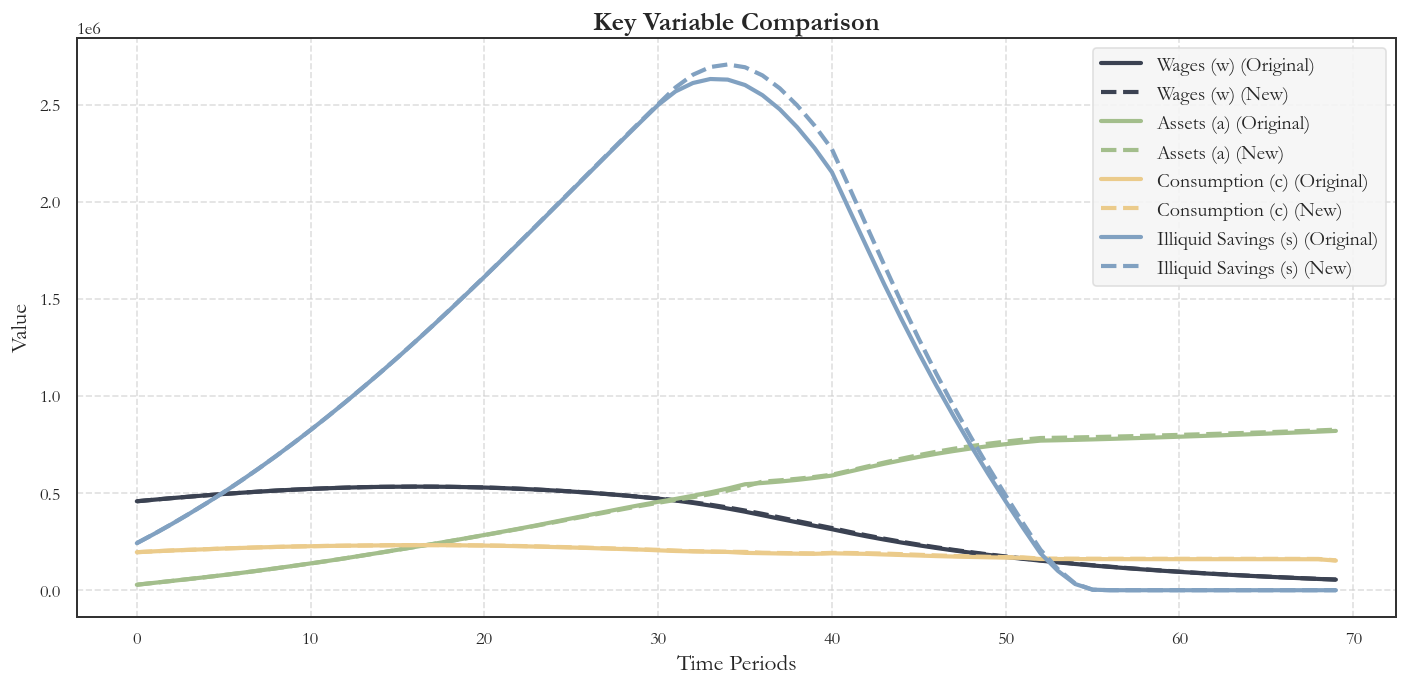

In [9]:
time = np.arange(par.T)

# Data for selected summary variables
summary_vars = ["Wages (w)", "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"]
simulated_data_new = {
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0),
}
simulated_data_og = {
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0),
}

plot_comparison_single_panel(simulated_data_og, simulated_data_new, summary_vars, time, save_title="counterfactual_summary_vars.png")


C:\Users\Peter\AppData\Local\Temp\ipykernel_9516\65369719.py:5: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0),
C:\Users\Peter\AppData\Local\Temp\ipykernel_9516\65369719.py:17: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),
C:\Users\Peter\AppData\Local\Temp\ipykernel_9516\65369719.py:29: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0)
C:\Users\Peter\AppData\Local\Temp\ipykernel_9516\65369719.py:30: RuntimeWarning: Mean of empty slice
  - np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),


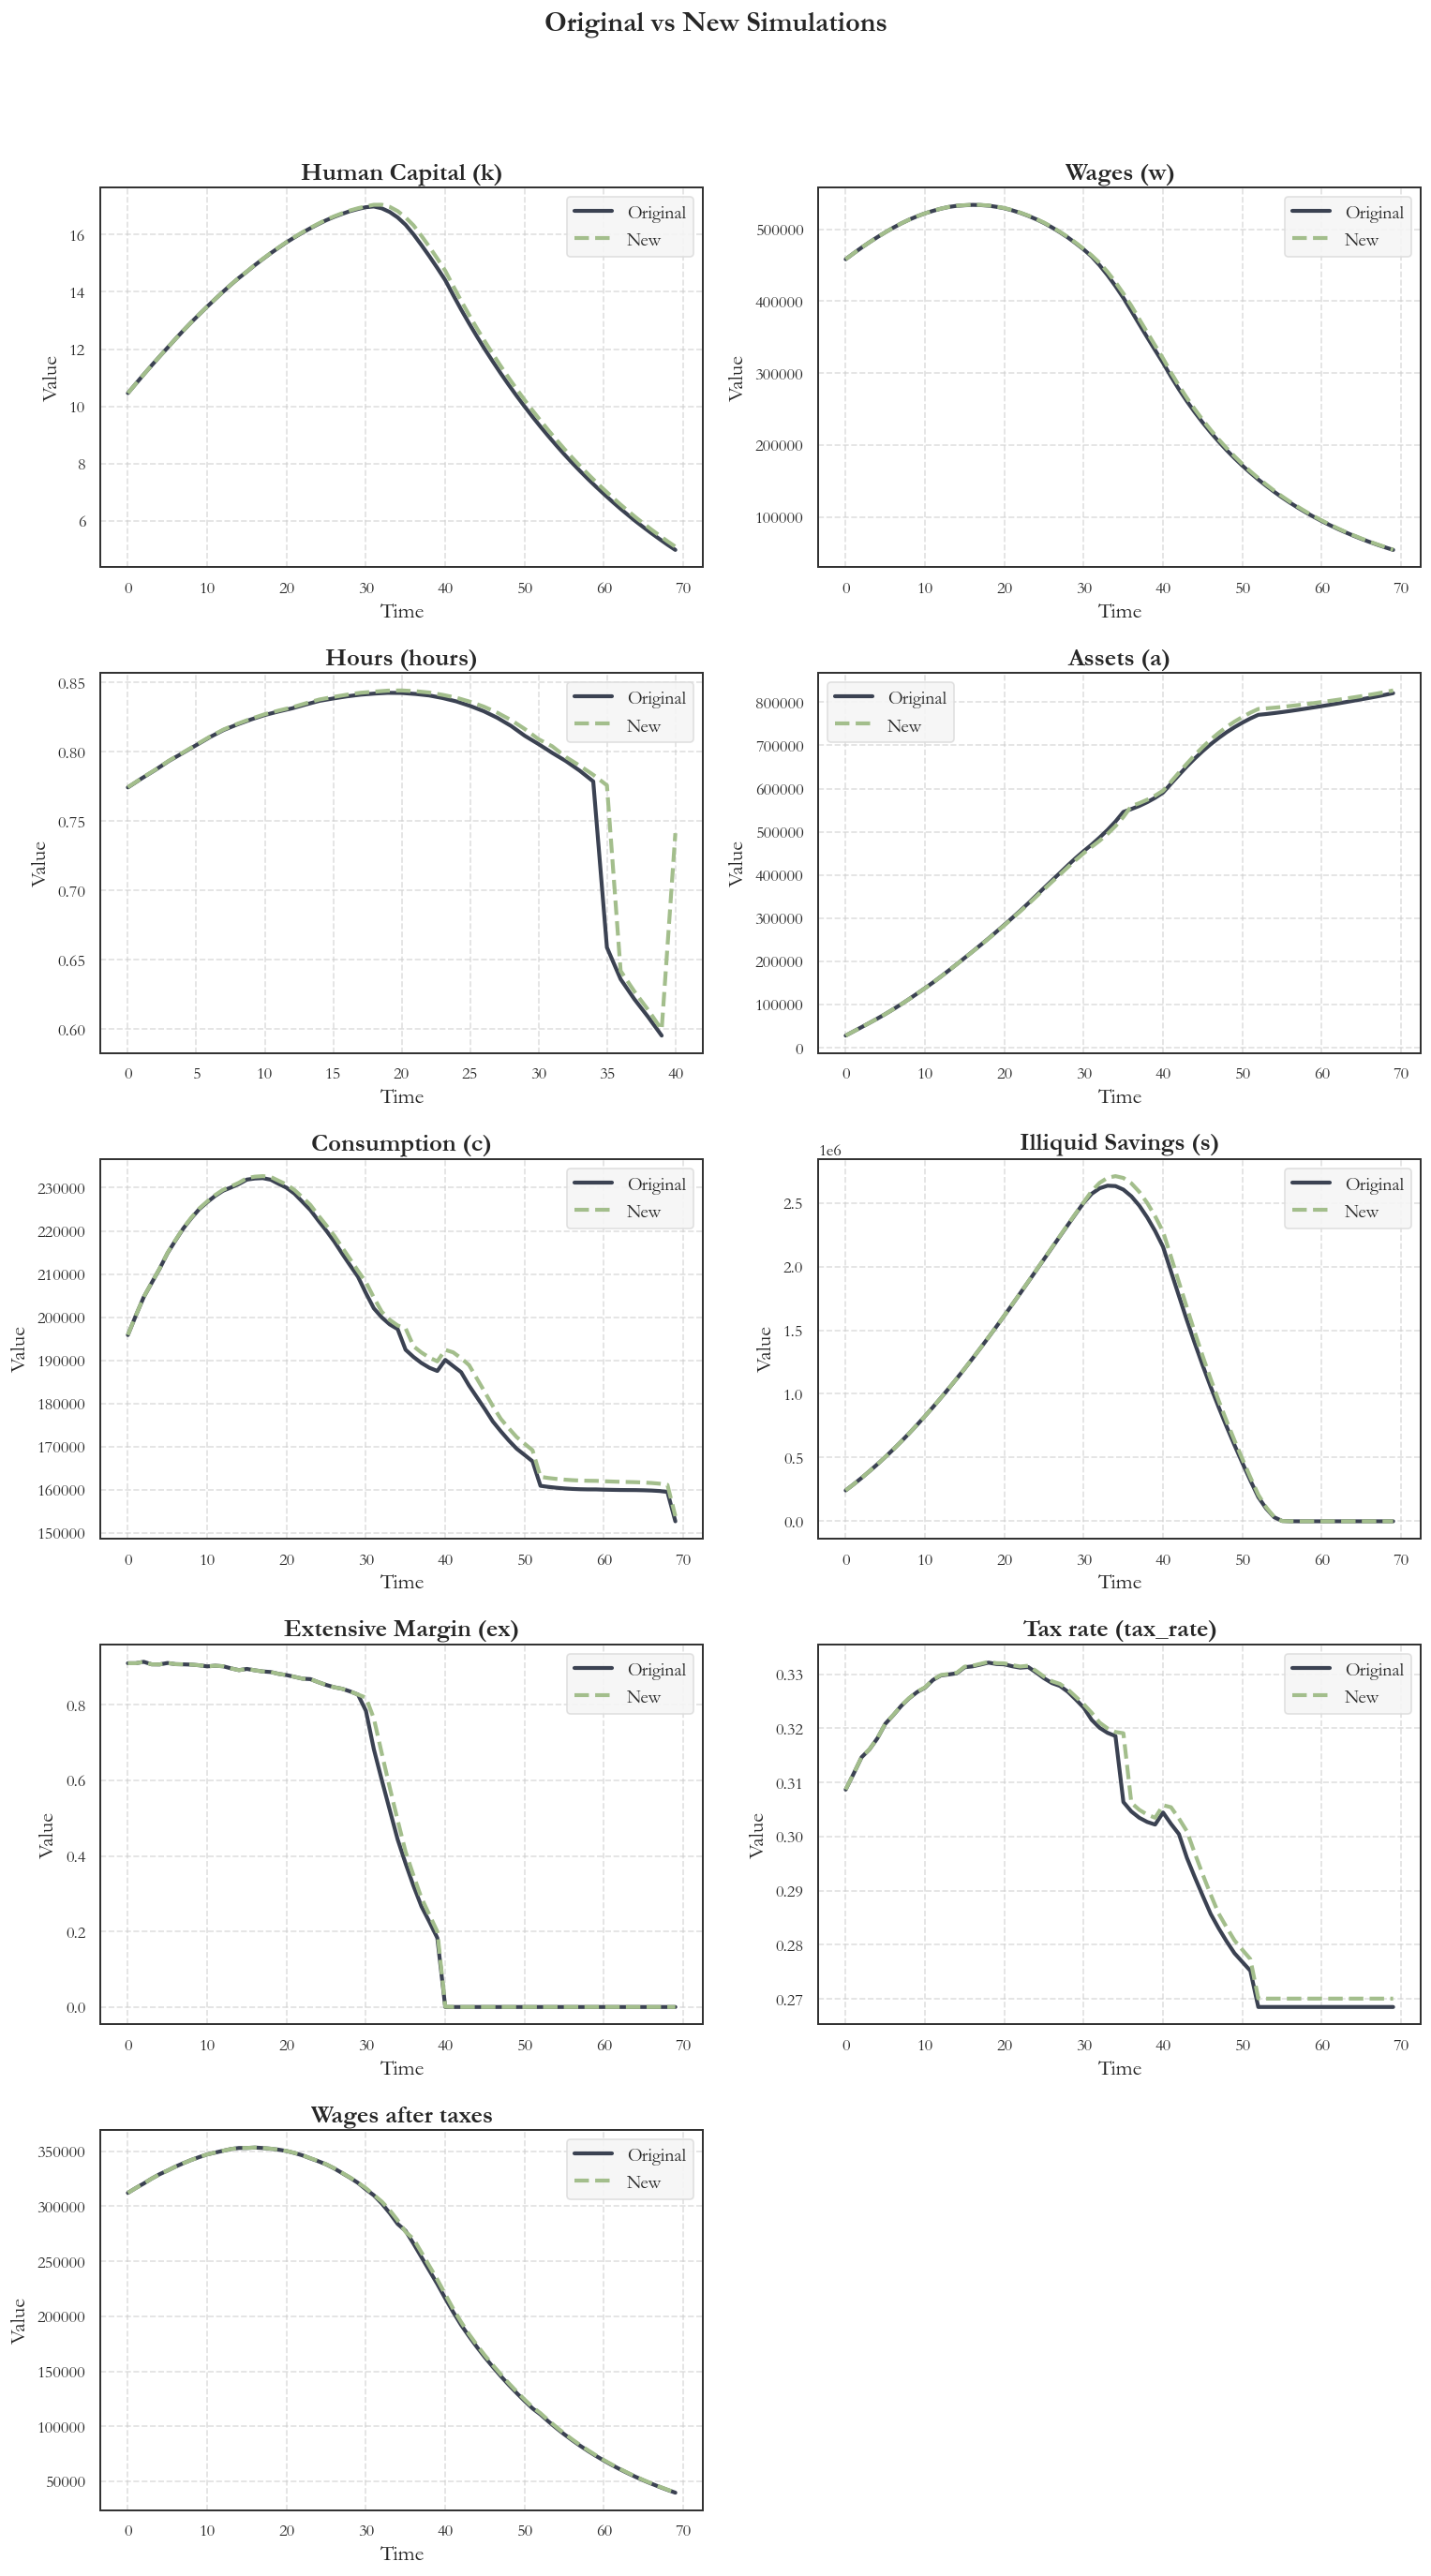

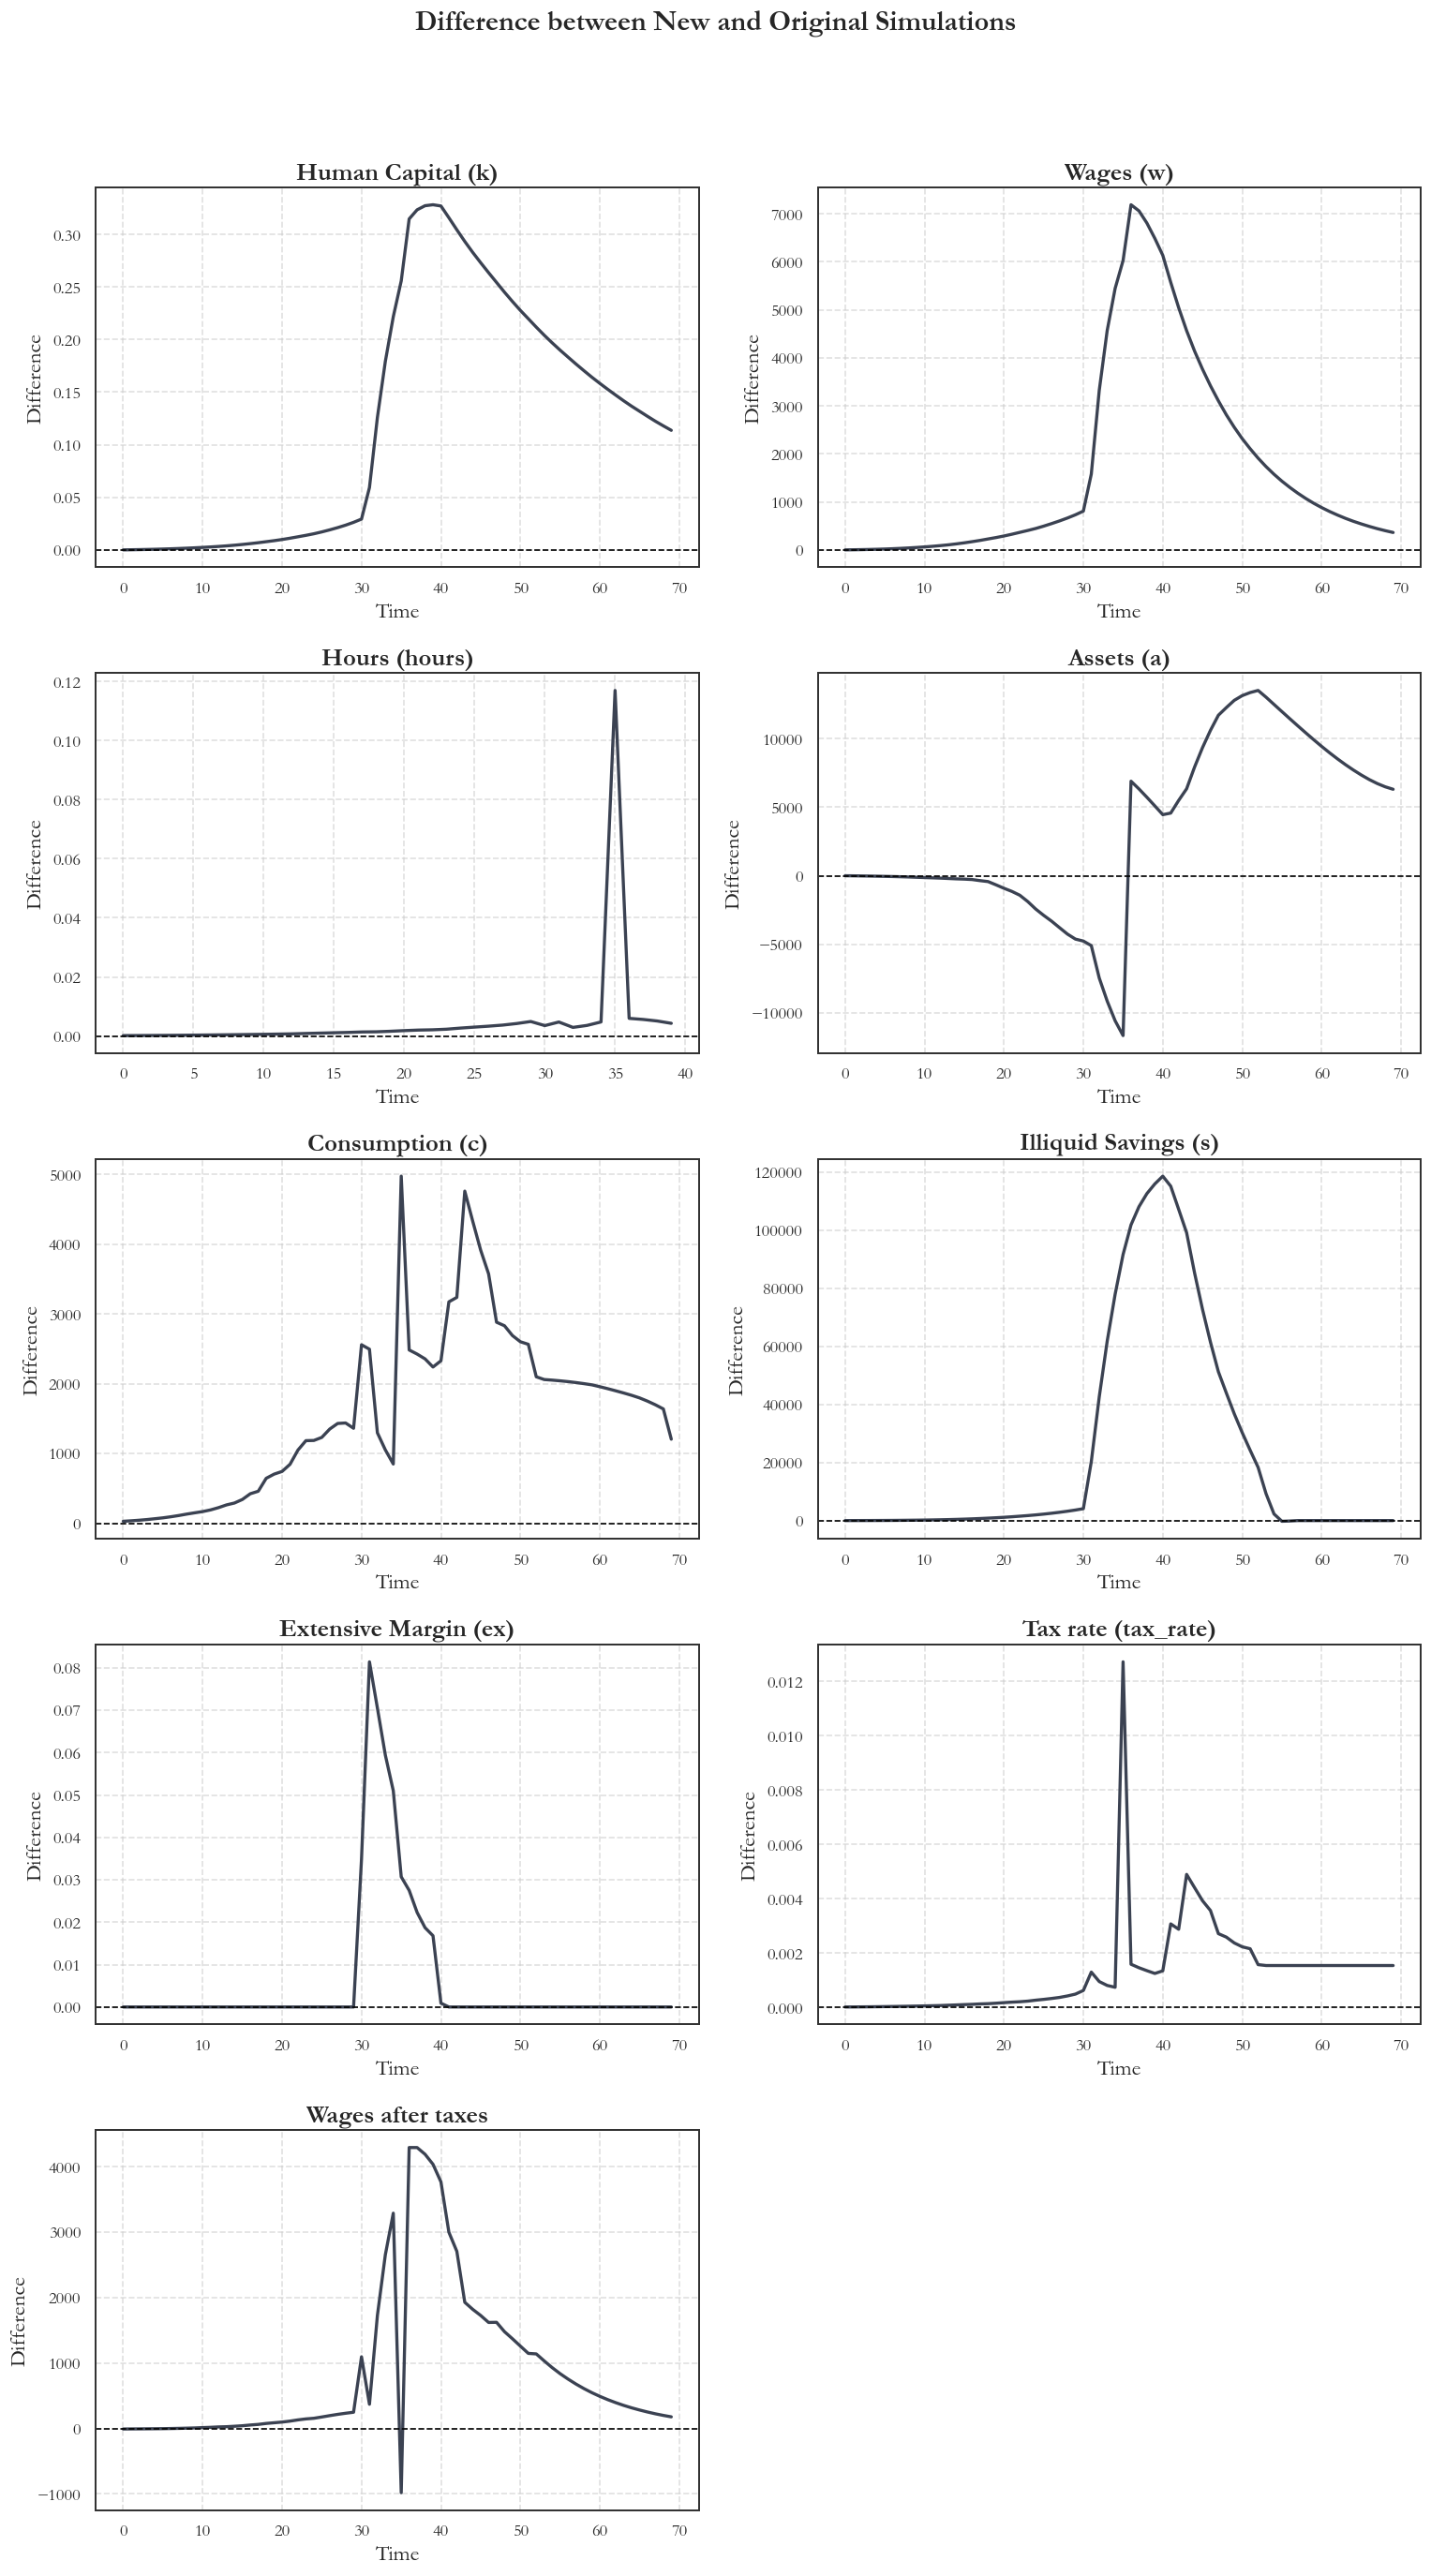

In [10]:

# Full variable set
data_dict_new = {
    "Human Capital (k)": np.mean(new_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(new_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(new_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": np.mean((1 - new_model.sim.tax_rate[:,:]) * new_model.sim.w[:,:], axis=0),
}

data_dict_og = {
    "Human Capital (k)": np.mean(og_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(og_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(og_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": np.mean((1 - og_model.sim.tax_rate[:,:]) * og_model.sim.w[:,:], axis=0),
}

data_dict_diff = {
    "Human Capital (k)": np.mean(new_model.sim.k[:], axis=0) - np.mean(og_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0) - np.mean(og_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0)
                    - np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0) - np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0) - np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0) - np.mean(og_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(new_model.sim.ex[:], axis=0) - np.mean(og_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(new_model.sim.tax_rate[:,:], axis=0) - np.mean(og_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": (
        np.mean((1 - new_model.sim.tax_rate[:,:]) * new_model.sim.w[:,:], axis=0)
        - np.mean((1 - og_model.sim.tax_rate[:,:]) * og_model.sim.w[:,:], axis=0)
    ),
}

plot_comparison_grid(data_dict_og, data_dict_new, time, title="Original vs New Simulations", save_title="counterfactual_full_vars.png")
plot_difference_grid(data_dict_diff, time, title="Difference between New and Original Simulations", save_title="counterfactual_diff_full_vars.png")


In [11]:
# 1. Find last time ex == 1 for each individual
last_working = np.full(og_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(og_model.sim.ex.shape[0]):
    working = np.where(og_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working.size > 0:
        last_working[i] = working[-1]  # last time they worked (take last index)

# 1. Find last time ex == 1 for each individual
last_working_new = np.full(new_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(new_model.sim.ex.shape[0]):
    working_new = np.where(new_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working_new.size > 0:
        last_working_new[i] = working_new[-1]  # last time they worked (take last index)


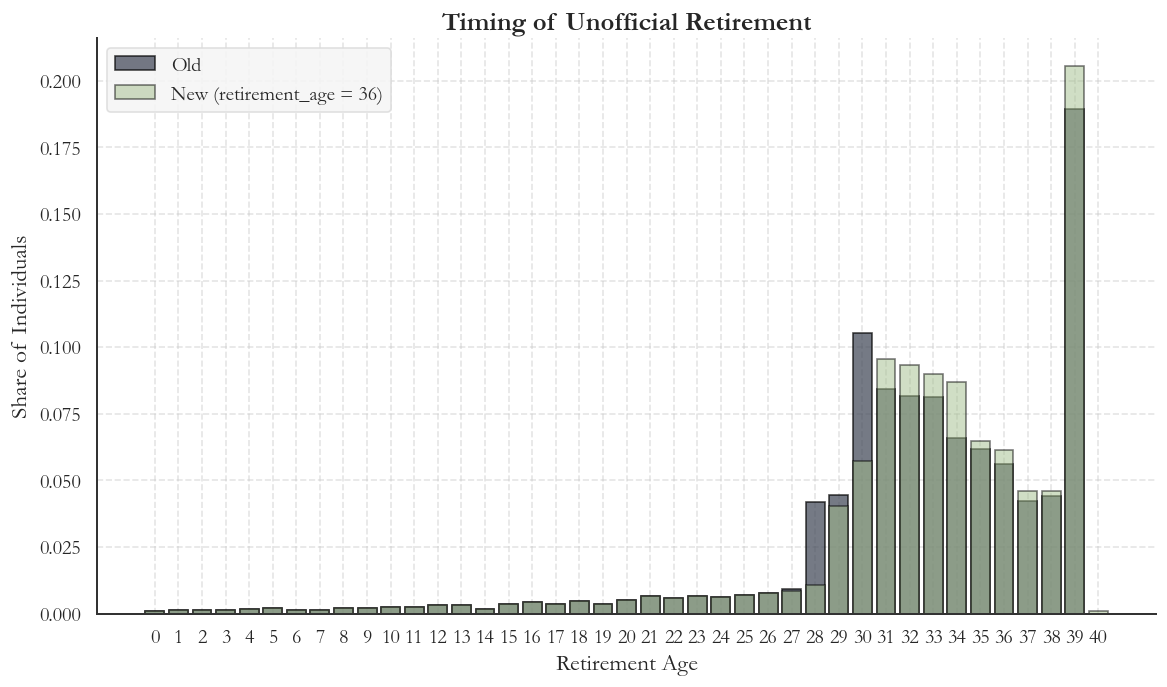

In [12]:
plot_event_bar_series(
    values1=last_working,
    values2=last_working_new,
    xlabel="Retirement Age",
    title="Timing of Unofficial Retirement",
    label1="Old",
    label2=f'New ({theta_names[0]} = {theta[0]})',
    save_title="counterfactual_retirement_age.png",
)


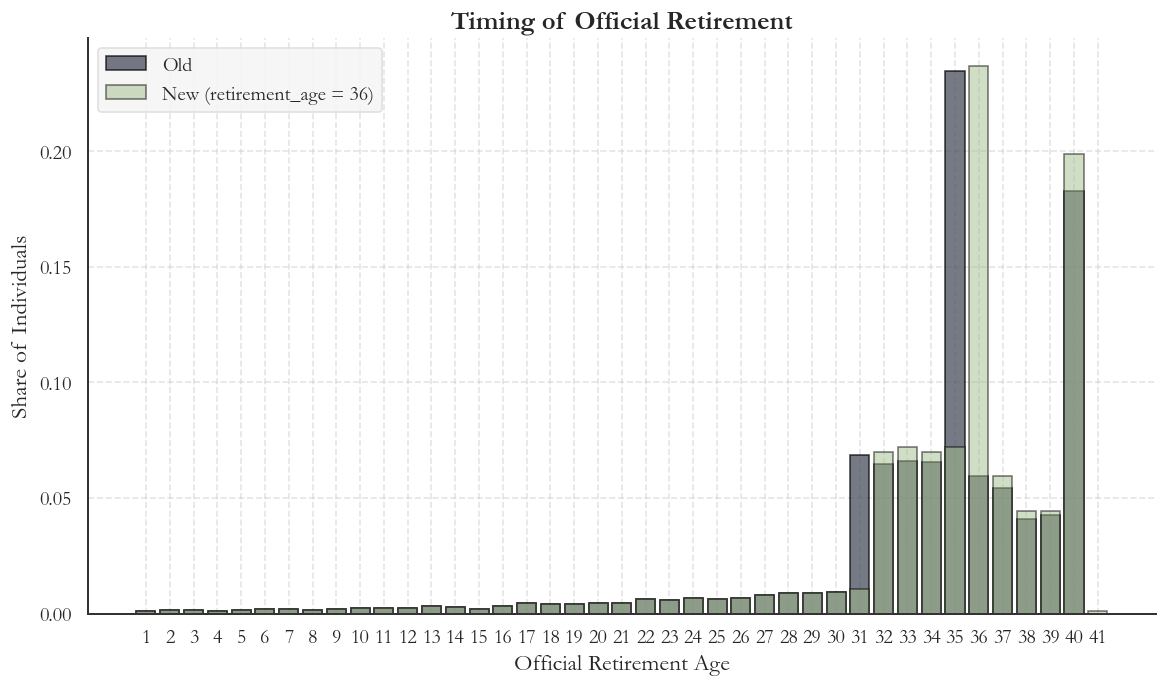

In [13]:
# 1. Find first time e == 2 for each individual
first_retirement = np.full(og_model.sim.e.shape[0], np.nan)  # initialize

for i in range(og_model.sim.e.shape[0]):
    retired = np.where(og_model.sim.e[i, :] == 2)[0]  # find where e=2
    if retired.size > 0:
        first_retirement[i] = retired[0]  # first time they retire

first_retirement_new = np.full(new_model.sim.e.shape[0], np.nan)  # initialize

for i in range(new_model.sim.e.shape[0]):
    retired_new = np.where(new_model.sim.e[i, :] == 2)[0]  # find where e=2
    if retired_new.size > 0:
        first_retirement_new[i] = retired_new[0]  # first time they retire
plot_event_bar_series(
    values1=first_retirement,
    values2=first_retirement_new,
    xlabel="Official Retirement Age",
    title="Timing of Official Retirement",
    label1="Old",
    label2=f'New ({theta_names[0]} = {theta[0]})',
    save_title="counterfactual_official_retirement_age.png",
)


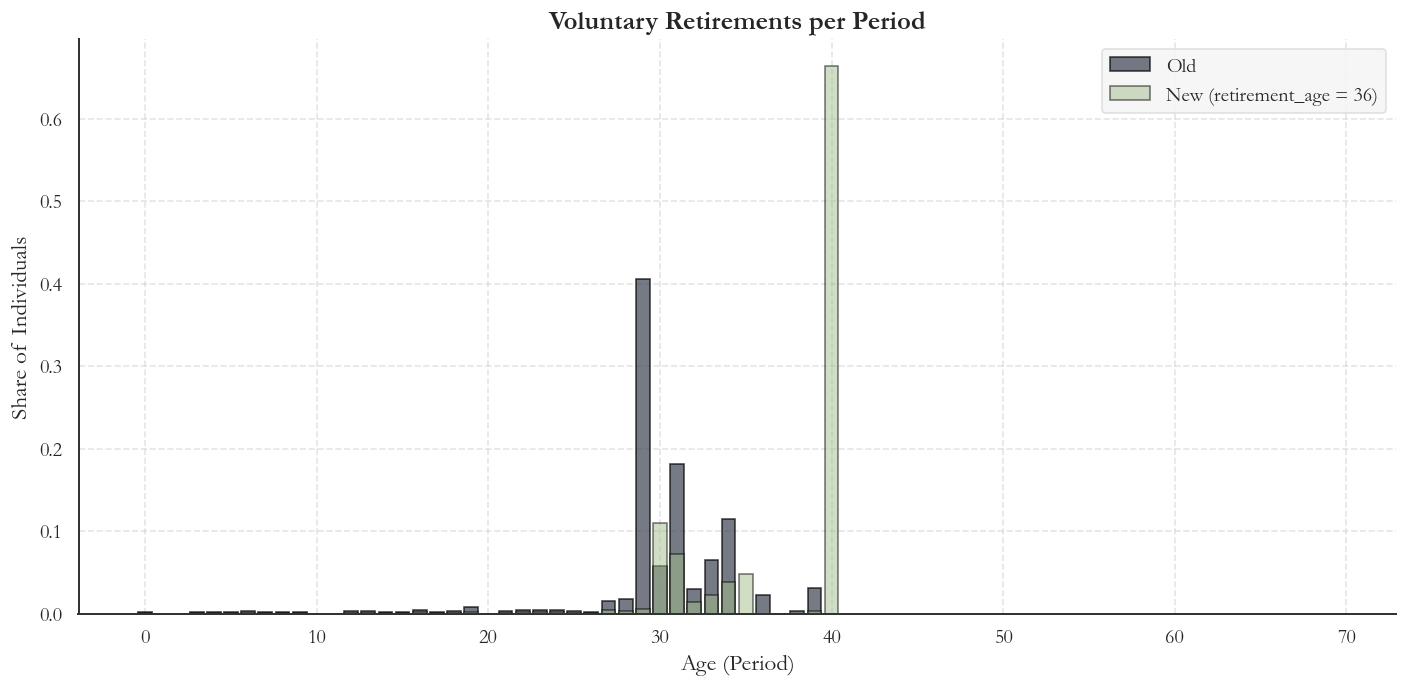

In [14]:
og_ret_counts = np.sum(og_model.sim.ret_flag[:, :], axis=0)
new_ret_counts = np.sum(new_model.sim.ret_flag[:, :], axis=0)
plot_bar_series_comparison(
    og_ret_counts,
    new_ret_counts,
    label1="Old",
    label2=f"New (retirement_age = {theta[0]})",
    title="Voluntary Retirements per Period",
    xlabel="Age (Period)",
    normalize=True,
    save_title="counterfactual_retirement_counts.png",
)


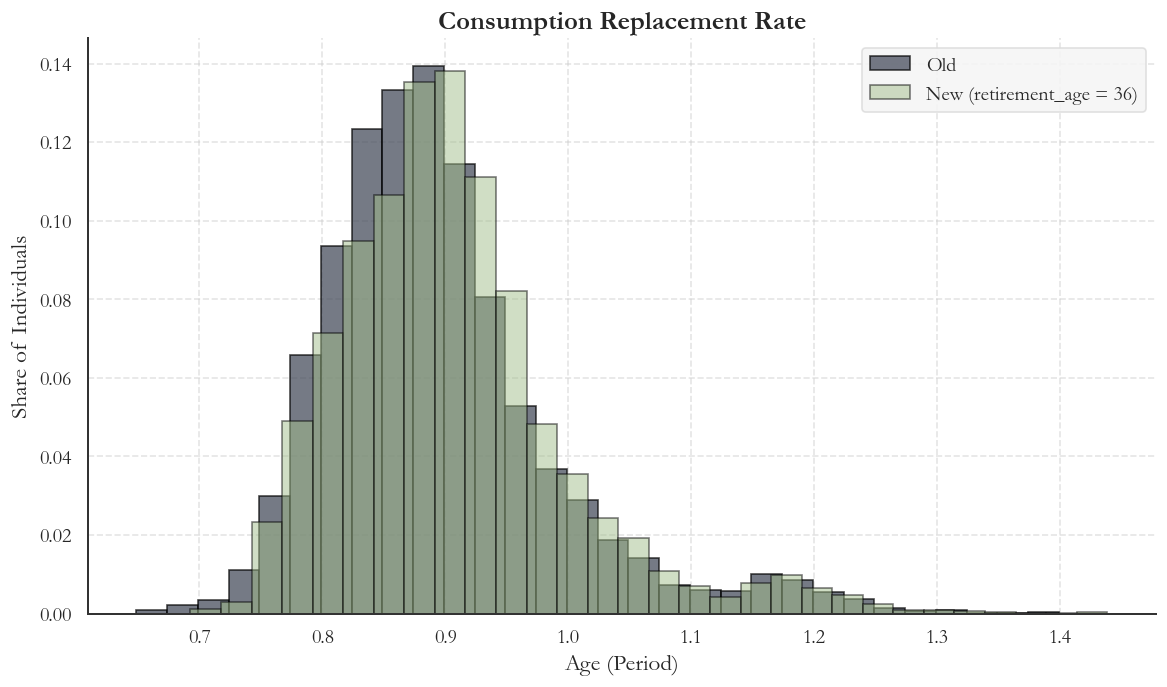

In [15]:
plot_event_histogram(
    values1=consumption_replacement_rate_fct(og_model),
    values2=consumption_replacement_rate_fct(new_model),
    xlabel="Age (Period)",
    title="Consumption Replacement Rate",
    label1="Old",
    label2=f'New ({theta_names[0]} = {theta[0]})',
    bins=30,
    save_title="counterfactual_consumption_replacement_histogram.png",
)

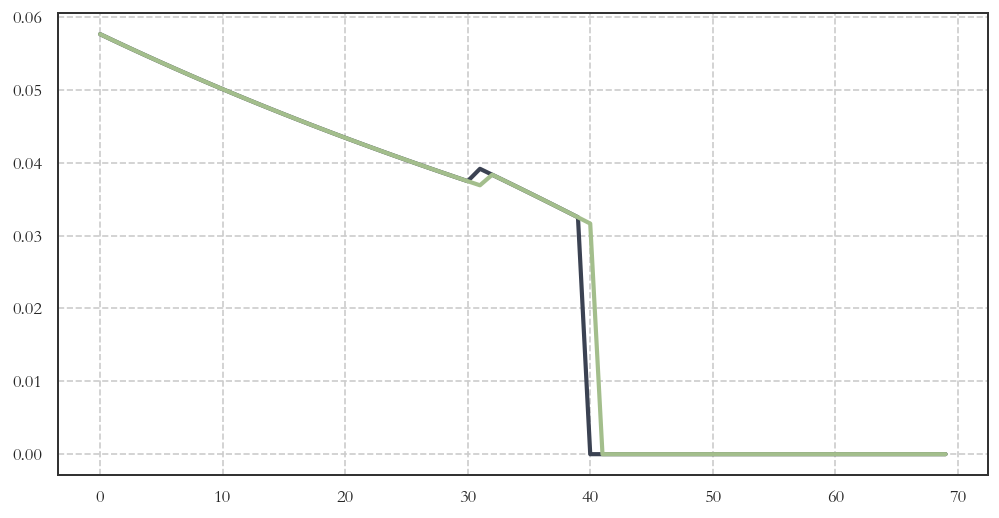

In [16]:
plt.plot(og_model.par.p_e_0)
plt.plot(new_model.par.p_e_0)

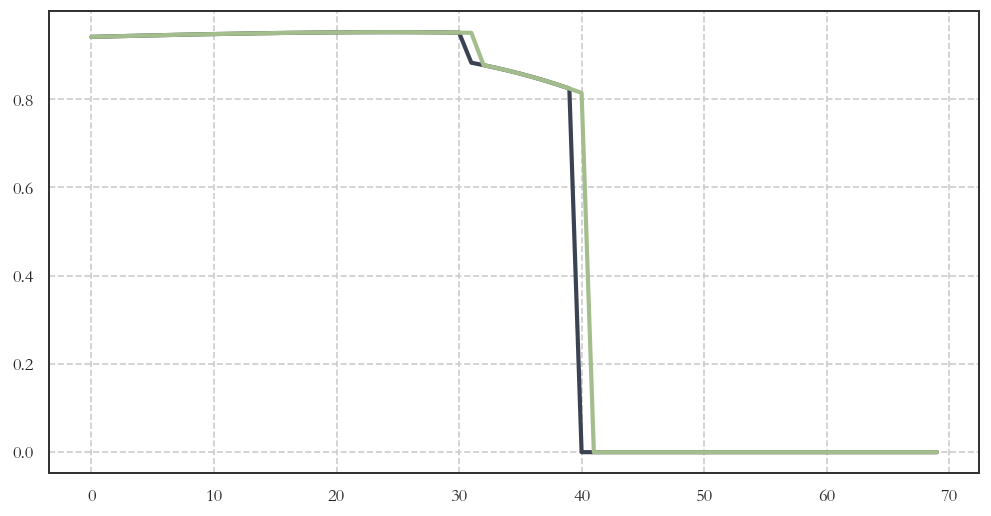

In [17]:
plt.plot(og_model.par.p_e_1)
plt.plot(new_model.par.p_e_1)

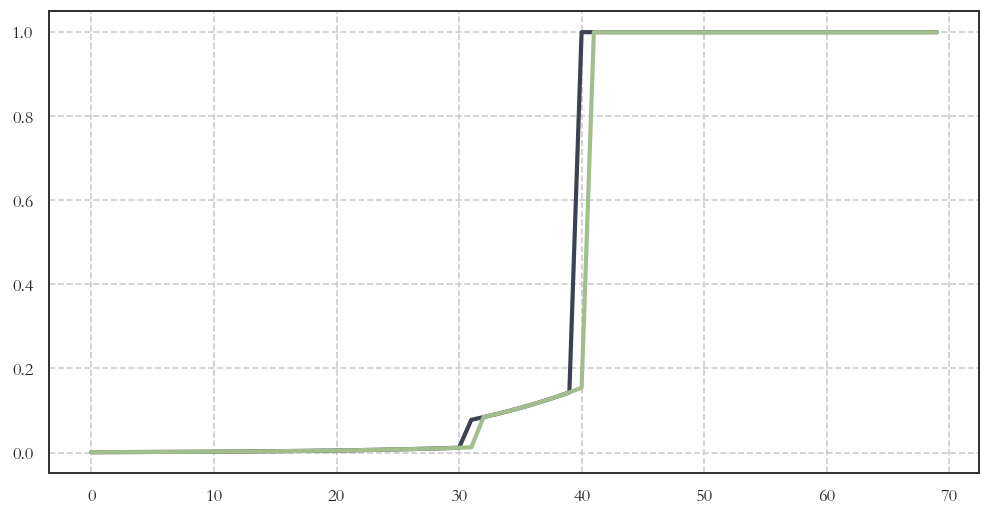

In [18]:
plt.plot(og_model.par.p_e_2)
plt.plot(new_model.par.p_e_2)

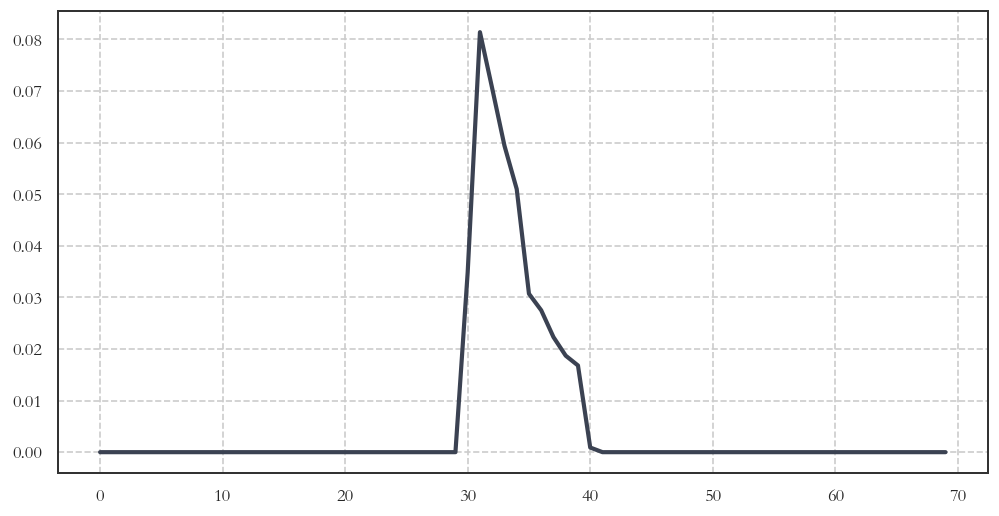

In [19]:
plt.plot(np.mean(new_model.sim.ex, axis=0)-np.mean(og_model.sim.ex, axis=0))

In [20]:
np.mean(new_model.sim.ex, axis=0)

array([9.100e-01, 9.100e-01, 9.137e-01, 9.070e-01, 9.068e-01, 9.106e-01,
       9.075e-01, 9.070e-01, 9.063e-01, 9.045e-01, 9.016e-01, 9.034e-01,
       9.019e-01, 8.964e-01, 8.917e-01, 8.949e-01, 8.913e-01, 8.882e-01,
       8.867e-01, 8.818e-01, 8.786e-01, 8.739e-01, 8.691e-01, 8.679e-01,
       8.598e-01, 8.525e-01, 8.464e-01, 8.424e-01, 8.354e-01, 8.270e-01,
       8.189e-01, 7.637e-01, 6.713e-01, 5.812e-01, 4.944e-01, 4.106e-01,
       3.479e-01, 2.886e-01, 2.441e-01, 1.996e-01, 9.000e-04, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

# Comparison of retirement age

# replacement rates

In [21]:
assert False

AssertionError: 

# Optimal retirement payments according to welfare

In [ ]:
def objective_func(tau_values, model):
    time = np.arange(par.T)

    constant, beta1, beta2 = tau_values

    tau = np.maximum((constant + beta1*time + beta2*time**2) / 100, 0)

    theta = [tau]
    theta_names = ['tau']

    og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)

    consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= False, the_method = 'brentq')

    print(consumption_eq, tau_values)
    return -consumption_eq

tau_values_init = np.array([1.35e+01, 8.00e-02, 5.00e-04])

bounds  = [(0,  30), 
           (-0.5,  0.5), 
           (-0.005,  0.005)]

res = minimize(objective_func, tau_values_init, args=(model, ),  
               method='Nelder-Mead', 
               bounds=bounds,
               options={'maxiter': 500})

print(res.x)

# Optimal retirement payments according to welfare conditioning on pension being the same

In [ ]:
def objective_func(tau_values, model):
    time = np.arange(par.T)

    constant, beta1, beta2 = tau_values

    tau = np.maximum((constant + beta1*time + beta2*time**2) / 100, 0)

    theta = [tau]
    theta_names = ['tau']

    og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)

    consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= False, the_method = 'brentq')

    if np.mean(og_model.sim.s[:, 35]) > np.mean(new_model.sim.s[:, 35]):
        consumption_eq = -9999.9

    print(consumption_eq, tau_values)
    return -consumption_eq

tau_values_init = np.array([ 2.0, 0.4,  0.001])

bounds  = [(0,  30), 
           (-0.5,  0.5), 
           (-0.005,  0.005)]

res = minimize(objective_func, tau_values_init, args=(model, ),  
               method='Nelder-Mead', 
               bounds=bounds,
               options={'maxiter': 500})

print(res.x)

In [ ]:
# constant, beta1, beta2 = np.array([ 1.46922503e+01, -2.31206543e-02,  6.27520107e-04]) # Current optimal giving 0.0065521344388923845 consumption eq.
constant, beta1, beta2 = np.array([ 1.48536631e+01, -4.18610966e-02,  6.47243901e-04]) # Test start


time = np.arange(par.T)

tau = np.maximum((constant + beta1*time + beta2*time**2) / 100, 0)

plt.plot(tau)
plt.plot(par.tau)
plt.show()


In [ ]:
theta = [tau]
theta_names = ['tau']

og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)

In [ ]:
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:40],
              moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40],
                  moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None),
                 moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}

# set up 2x2 axes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (key, (sim, emp)) in zip(axes, a_dict.items()):
    x_vals = np.arange(len(emp)) + par.start_age

    # real data: solid grey
    ax.plot(x_vals, emp,
            color='grey',
            linestyle='-',
            linewidth=2,
            label=f"Real {key.capitalize()}")

    # simulated data: darker dashed
    ax.plot(x_vals, sim,
            color='black',
            linestyle='--',
            linewidth=2,
            label=f"Simulated {key.capitalize()}")

    ax.set_xlabel("Age")
    ax.set_ylabel(key.capitalize())
    ax.set_title(key.capitalize())
    ax.grid(True)
    ax.legend()

fig.tight_layout()
plt.show()
